### 5.4.1 곱셈 계층

In [5]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [6]:
# 사과 2개 사기

apple = 100
num_apple = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, num_apple)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [7]:
# 역전파

dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 5.4.2 덧셈 계층

In [8]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [9]:
# 사과 2개, 귤 3개

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange_num, dorange, dtax)

715.0000000000001
110.00000000000001 2.2 165.0 3.3000000000000003 650


## 5.5 활성화 함수 계층 구현

### 5.5.1 ReLU

In [11]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = x <= 0
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

### 5.5.2 Sigmoid

In [12]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx
    

## 5.6 Affine / Softmax

### 5.6.2 배치용 Affine

In [13]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [14]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블 (one-hot 벡터)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

### 5.7.2 오차역전파법을 적용한 신경망 구현

In [15]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

In [16]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 5.7.3 기울기 검증

In [17]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ': ' + str(diff))

W1: 3.7161550208993413e-10
b1: 2.0542781933266455e-09
W2: 4.979820380776639e-09
b2: 1.3979765418753453e-07


### 5.7.4 오차역전파법을 사용한 학습 구현

In [18]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)
    

0.10048333333333333 0.1003
0.90125 0.9042
0.9226833333333333 0.9231
0.936 0.9347
0.9450666666666667 0.9415
0.9503333333333334 0.9473
0.9547833333333333 0.953
0.9591 0.9564
0.9636333333333333 0.9595
0.96635 0.9624
0.96845 0.9629
0.9694 0.9649
0.9731833333333333 0.9654
0.975 0.9673
0.9769 0.9673
0.97685 0.9686
0.978 0.9675


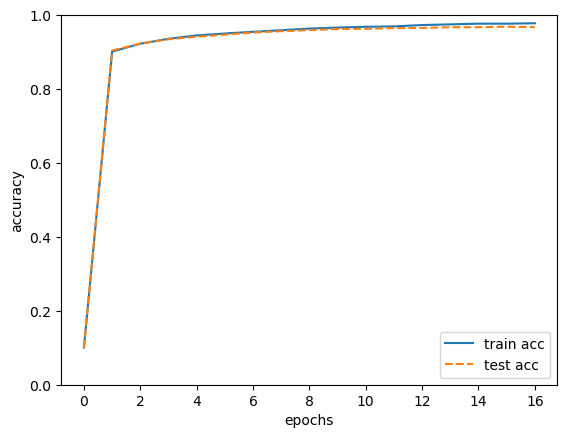

In [20]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()